## Multi Classification with Precision Recall

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading monitored datafile...
Total monitored samples: 19000
Loading unmonitored datafile...
Total combined samples: 22000
Training Open-World Multi-Class Decision Tree model...
Multi-Class Classification Accuracy (Decision Tree): 0.8473

Multi-Class Classification Report (Decision Tree):
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       590
           0       0.84      0.70      0.76        30
           1       0.91      0.89      0.90        44
           2       0.83      0.83      0.83        41
           3       0.90      0.85      0.88        33
           4       0.76      0.81      0.79        32
           5       0.82      0.89      0.86        37
           6       0.84      0.95      0.89        38
           7       0.72      0.74      0.73        35
           8       0.73      0.73      0.73        33
           9       0.41      0.62      0.49        26
          10       0.92      0.79      0.85        43
       

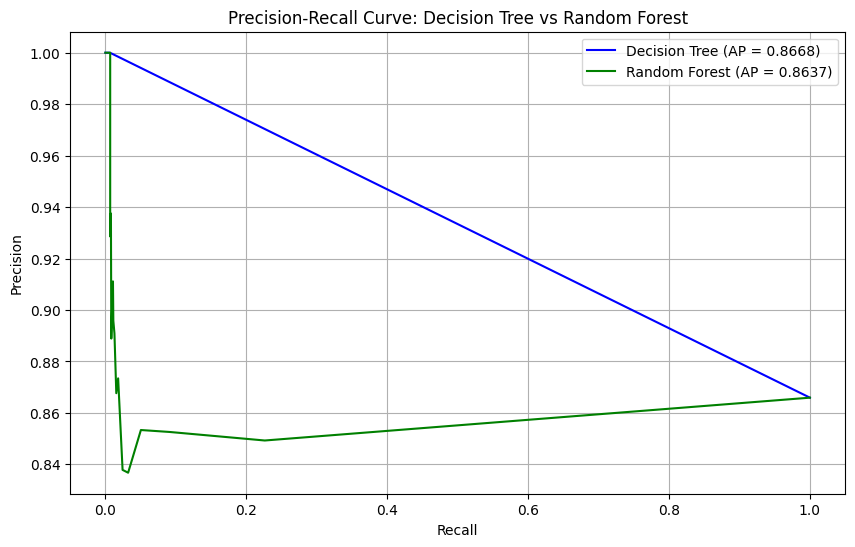

In [ ]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Monitored data
USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS = 950

print("Loading monitored datafile...")  
with open("/content/drive/MyDrive/mon_standard.pkl", "rb") as file:  
    data = pickle.load(file)

X_timestamps = []  # Packet timestamps
X_packet_sizes = []  # Packet sizes
X_cum_sizes = []  # Cumulative packet size
y_monitored = []  # Labels

for i in range(TOTAL_URLS):
    label = i if USE_SUBLABEL else i // URL_PER_SITE
    for sample in data[i]:
        timestamps = np.empty(len(sample), dtype=np.float32)
        packet_sizes = np.empty(len(sample), dtype=np.int16)
        cum_sizes = np.empty(len(sample), dtype=np.int32)

        cumulative_sum = 0
        for j, c in enumerate(sample):
            dr = 1 if c > 0 else -1
            timestamps[j] = abs(c)
            packet_sizes[j] = dr * 512
            cumulative_sum += packet_sizes[j]
            cum_sizes[j] = cumulative_sum

        X_timestamps.append(timestamps)
        X_packet_sizes.append(packet_sizes)
        X_cum_sizes.append(cum_sizes)
        y_monitored.append(label)

print(f"Total monitored samples: {len(y_monitored)}")  # Output: 19,000

# Unmonitored data
TOTAL_UNMON_URLS = 3000

print("Loading unmonitored datafile...")
with open("/content/drive/MyDrive/unmon_standard10_3000.pkl", "rb") as f:  
    x = pickle.load(f)

for i in range(TOTAL_UNMON_URLS):
    sample = x[i]
    timestamps = np.empty(len(sample), dtype=np.float32)
    packet_sizes = np.empty(len(sample), dtype=np.int16)
    cum_sizes = np.empty(len(sample), dtype=np.int32)

    cumulative_sum = 0
    for j, c in enumerate(sample):
        dr = 1 if c > 0 else -1
        timestamps[j] = abs(c)
        packet_sizes[j] = dr * 512
        cumulative_sum += packet_sizes[j]
        cum_sizes[j] = cumulative_sum

    X_timestamps.append(timestamps)
    X_packet_sizes.append(packet_sizes)
    X_cum_sizes.append(cum_sizes)
    y_monitored.append(-1)  # Label unmonitored data as -1

print(f"Total combined samples: {len(y_monitored)}")

# padding
max_length = max(len(seq) for seq in X_timestamps)

def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen), dtype=np.float32)
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq)] = seq[:maxlen]
    return padded_sequences

X_timestamps_padded = pad_sequences(X_timestamps, max_length)
X_packet_sizes_padded = pad_sequences(X_packet_sizes, max_length)
X_cum_sizes_padded = pad_sequences(X_cum_sizes, max_length)

# feature combination
X_combined = np.hstack((X_timestamps_padded, X_packet_sizes_padded, X_cum_sizes_padded))

# data split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_monitored, test_size=0.2, random_state=42)

# Binary Classification (Monitored vs Unmonitored)
binary_y_train = np.where(np.array(y_train) == -1, -1, 1)  # Monitored(1), Unmonitored(-1)
binary_y_test = np.where(np.array(y_test) == -1, -1, 1)

# Decision Tree Multi-Class Classification (Monitored and Unmonitored)
print("Training Open-World Multi-Class Decision Tree model...")
dt_multi_model = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dt_multi_model.fit(X_train, y_train)

multi_y_pred_dt = dt_multi_model.predict(X_test)
multi_accuracy_dt = accuracy_score(y_test, multi_y_pred_dt)

print(f"Multi-Class Classification Accuracy (Decision Tree): {multi_accuracy_dt:.4f}")
print("\nMulti-Class Classification Report (Decision Tree):")
print(classification_report(y_test, multi_y_pred_dt))

# Calculate precision and recall for Decision Tree
dt_probs = dt_multi_model.predict_proba(X_test)
dt_probs_monitored = dt_probs[:, 1]  # Probability of being monitored (class != -1)
dt_precision, dt_recall, _ = precision_recall_curve(binary_y_test, dt_probs_monitored, pos_label=1)
dt_avg_precision = average_precision_score(binary_y_test, dt_probs_monitored)

# Random Forest Multi-Class Classification (Monitored and Unmonitored)
print("Training Open-World Multi-Class Random Forest model...")
rf_multi_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_multi_model.fit(X_train, y_train)

multi_y_pred = rf_multi_model.predict(X_test)
multi_accuracy = accuracy_score(y_test, multi_y_pred)

print(f"Multi-Class Classification Accuracy (Random Forest): {multi_accuracy:.4f}")
print("\nMulti-Class Classification Report (Random Forest):")
print(classification_report(y_test, multi_y_pred))

# Calculate precision and recall for Random Forest
rf_probs = rf_multi_model.predict_proba(X_test)
rf_probs_monitored = rf_probs[:, 1]  # Probability of being monitored (class != -1)
rf_precision, rf_recall, _ = precision_recall_curve(binary_y_test, rf_probs_monitored, pos_label=1)
rf_avg_precision = average_precision_score(binary_y_test, rf_probs_monitored)

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(dt_recall, dt_precision, label=f"Decision Tree (AP = {dt_avg_precision:.4f})", color='blue')
plt.plot(rf_recall, rf_precision, label=f"Random Forest (AP = {rf_avg_precision:.4f})", color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Decision Tree vs Random Forest')
plt.legend(loc='best')
plt.grid()
plt.show()